# Analysis of Foursquare Data

# NYU - CUSP UDP Capstone
# Foursquare + NYC Merge by CT 
## Brief
This notebook 
1. Part I. Data Processing

    - import Foursquare data
    - imports the Census Tract shapefile
    - import Typologies
    - merges topologies
    - Spatail join by Census Tract
    - merges topologies
    - map topologies
    - map Businesses
1. Part II. Modeling
    - Performs a classifcation task on Typologies
###  You can refer to https://github.com/mv1742/updny_2

In [2]:
import os
import requests
import shapely
import json

# !pip install pydotplus
from sklearn import tree
# from IPython.display import Image  
# import pydotplus

import matplotlib.pyplot as plt #plotting
import pandas as pd
import numpy as np
import scipy.stats as stat
#make sure plots are embedded into the notebook
%matplotlib inline
#import statsmodels.formula.api as smf
import itertools
import geopandas as gpd
from shapely.geometry import Point, Polygon
from sklearn.metrics import silhouette_score
# from sklearn.mixture import GaussianMixture
from scipy import linalg
import matplotlib as mpl
from sklearn import preprocessing
from scipy.cluster.hierarchy import dendrogram, linkage  # for hierarchical clustering
from scipy.cluster.hierarchy import fcluster
# from sklearn.mixture import GaussianMixture
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
import geopandas as gpd
import pylab as pl
import io
import pylab as pl

from geopandas.tools import sjoin
try:
    import ipywidgets as widgets
    hasWidgets = True
except ImportError:
    hasWidgets = False
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.metrics import confusion_matrix
from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier



%pylab inline

Populating the interactive namespace from numpy and matplotlib


/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['Polygon', 'linalg']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


# Part I. Data Processing
## Foursquare Data
- import Foursquare data

In [3]:
data = gpd.read_file('NYU_March2018_subset30.geojson')

In [4]:
(list(data.columns)), data.shape

(['id',
  'Place Name',
  'Rating',
  'Checkins',
  'Users',
  'Visits',
  'Pricing',
  'Type',
  'Category',
  'Class',
  'geometry'],
 (106287, 11))

In [5]:
data.head(1)

,id,Place Name,Rating,Checkins,Users,Visits,Pricing,Type,Category,Class,geometry
0,50ad0afce4b0b4a7430e2268,Terry's Wine Shop,8.8,294,217,337,None,Wine Shop,Consumption,Optional,POINT (-74.00034036700906 40.73518392010902)


In [6]:
list(data.columns)[-4:-1]

['Type', 'Category', 'Class']

In [7]:
X_dummies = data[list(data.columns)[-4:-1]]
print(X_dummies.shape)
X_dummies = pd.get_dummies(X_dummies)
Fq_dummies = pd.concat([data, X_dummies], axis=1, join='inner')  
Fq_dummies.shape

(106287, 3)


(106287, 716)

# Census Tract shapefile
- imports the Census Tract shapefile


In [8]:
# create the directory for shapefiles and set the environmental variable to it

masterdata = os.getenv("Master")
if masterdata is None:
    os.environ["Master"] = "{}/Capstone/udpny_2".format(os.getenv("HOME"))
    masterdata = os.getenv("Master")
    print("Warning: Master environmental variable not found and set by code, please review!")
print("Master: {}".format(masterdata))

Master: /nfshome/mv1742/Capstone/udpny_2


In [9]:
# create the directory for shapefiles and set the environmental variable to it

masterdata = os.getenv("Master")
if masterdata is None:
    os.environ["Master"] = "{}/Capstone/udpny_2".format(os.getenv("HOME"))
    masterdata = os.getenv("Master")
    print("Warning: Master environmental variable not found and set by code, please review!")
print("Master: {}".format(masterdata))
def getGeoDataFrameFromShpFileZipUrl(url):
    '''
    This function downloads the zip file, unzips it into the dorectory 
    pointed to by PUIdata environment variable. Then it 
    reads it into a gepandas dataframe
    '''
    
    folderName = 'shape'+ \
        str(len(os.listdir(os.getenv('TaxiData')))+1)
    os.makedirs(os.getenv('Master') + '/' + folderName)
    urlretrieve(url, "region.zip")
    os.system('unzip -d $Master'+'/'+folderName+' region.zip')
    filenames = [f for f in os.listdir(os.getenv('Master') + '/' + folderName) if f.endswith('.shp') ]
    shapeFile = filenames[0]
    shapeFilePath = os.getenv('Master') + '/' + folderName + '/' + shapeFile
    return gpd.GeoDataFrame.from_file(shapeFilePath)


Master: /nfshome/mv1742/Capstone/udpny_2


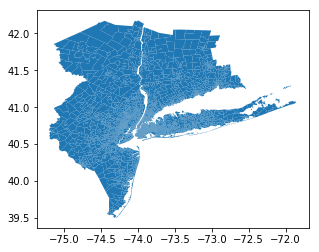

In [10]:
# url = 'https://planninglabs.carto.com/api/v2/sql?filename=region&q=SELECT%20%2A%20FROM%20region_censustract_v0&format=SHP'
# NYCzip = getGeoDataFrameFromShpFileZipUrl(url)
NYCzip=gpd.read_file('Censustracts/region.shp')
NYCzip.plot()


In [11]:
NYCzip.columns

Index(['aland_mi', 'objectid', 'statefp', 'countyfp', 'tractce', 'geoid',
       'name', 'namelsad', 'mtfcc', 'funcstat', 'aland', 'awater', 'intptlat',
       'intptlon', 'shape_leng', 'shape_area', 'atotal', 'atotal_mi',
       'cartodb_id', 'geoid_1', 'hou16', 'hou16moe', 'hou16cv', 'houv16',
       'houv16moe', 'houv16cv', 'houo16', 'houo16moe', 'houo16cv', 'hour16',
       'hour16moe', 'hour16cv', 'emtot15', 'empr15', 'emoff15', 'emins15',
       'emind15', 'emser15', 'emoth15', 'geometry'],
      dtype='object')

In [12]:
NYCzip.rename(columns={"geoid": "GEOID"},inplace=True)
NYCzip.GEOID = NYCzip.GEOID.astype(int)
cols = ['GEOID','geometry']
NYCzip = NYCzip.loc[:,cols]
#NYCzipgdp.plot(column='GEOID',legend = True)
NYCzip.shape
NYCzip.isnull().sum()

GEOID       0
geometry    0
dtype: int64

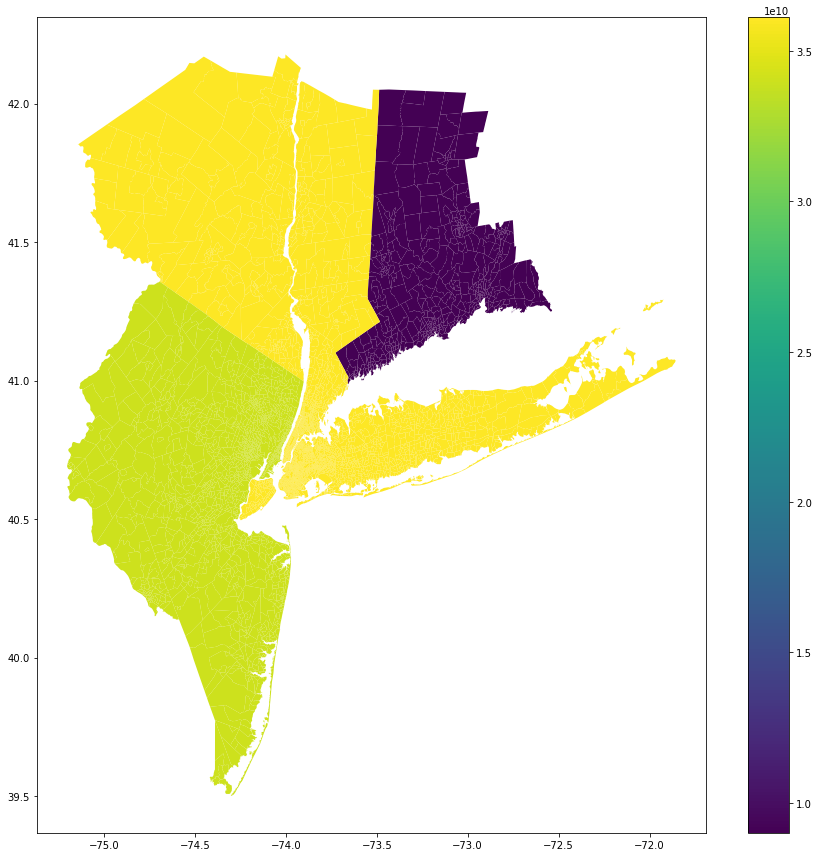

In [13]:
figure, ax = plt.subplots(figsize=(15, 15))
NYCzip.plot(column='GEOID',legend = True, ax=ax)

# Typologies
- import Typologies
- merges topologies
- map topologies

In [14]:
Typologiespd=pd.read_csv('NY_final_data_for_typologies_1.19.19.csv')
Typologiesgdp = gpd.GeoDataFrame(Typologiespd)
len(Typologiesgdp.columns)

82

In [15]:
Typologiesgdp['Type_1.19'].replace('MHI - Advanced Exclusion','MHI - Ongoing Exclusion',inplace=True)


In [16]:
Typologiesgdp['Type_1.19'].unique()

array(['VHI - Super Gentrification or Exclusion',
       'MHI - Ongoing Exclusion',
       'MHI - Stable or Early Stage of Exclusion',
       'LI - At Risk of Gentrification', 'MHI - Advanced Gentrification',
       'LI - Not Losing Low-Income Households',
       'LI - Ongoing Displacement of Low-Income Households',
       'Missing Data', 'LI - Ongoing Gentrification', nan], dtype=object)

In [17]:
Typologiesgdp['Type_1.19'].describe()

count                                         5294
unique                                           9
top       MHI - Stable or Early Stage of Exclusion
freq                                          2004
Name: Type_1.19, dtype: object

MHI - Stable or Early Stage of Exclusion              0.378542
MHI - Ongoing Exclusion                               0.143937
LI - At Risk of Gentrification                        0.098602
LI - Not Losing Low-Income Households                 0.091046
LI - Ongoing Displacement of Low-Income Households    0.087457
MHI - Advanced Gentrification                         0.069890
VHI - Super Gentrification or Exclusion               0.059312
LI - Ongoing Gentrification                           0.051946
Missing Data                                          0.019267
Name: Type_1.19, dtype: float64

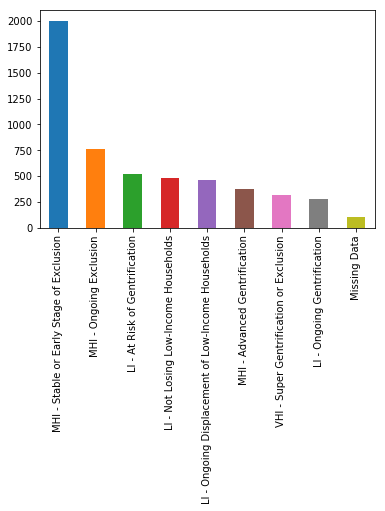

In [18]:
Typologiesgdp['Type_1.19'].value_counts().plot(kind='bar')
Typologiesgdp['Type_1.19'].value_counts()/Typologiesgdp['Type_1.19'].value_counts().sum()

In [19]:
Typologiesgdp['Type_1.19'].value_counts().sum()

5294

In [20]:
# Typologiesgdp['Type_binary'] = Typologiesgdp['Type_1.19']
# Typologiesgdp['Type_binary'].replace('VHI - Super Gentrification or Exclusion',1,inplace=True)
# Typologiesgdp['Type_binary'].replace('MHI - Ongoing Exclusion',0,inplace=True)
# Typologiesgdp['Type_binary'].replace('MHI - Stable or Early Stage of Exclusion',0,inplace=True)
# Typologiesgdp['Type_binary'].replace('MHI - Advanced Exclusion', 0,inplace=True)
# Typologiesgdp['Type_binary'].replace('MHI - Advanced Gentrification',1,inplace=True)
# Typologiesgdp['Type_binary'].replace('LI - At Risk of Gentrification',1,inplace=True)
# Typologiesgdp['Type_binary'].replace('LI - Ongoing Gentrification',1,inplace=True)
# Typologiesgdp['Type_binary'].replace('LI - Not Losing Low-Income Households',0,inplace=True)
# Typologiesgdp['Type_binary'].replace('LI - Ongoing Displacement of Low-Income Households',0,inplace=True)
# Typologiesgdp['Type_binary'].replace('Missing Data',0,inplace=True)
# Typologiesgdp['Type_binary'].replace(nan,0,inplace=True)


In [21]:
# Typologiesgdp['Type_binary'].unique()

In [22]:
# Typologiesgdp.to_csv('typologies_binary.csv')
# Typologiesgdp.drop(columns='Type_binary', inplace=True)

In [23]:
Typologiesgdp.rename(columns={'geoid': "GEOID"},inplace=True)
Typologiesgdp.tail()
cols_typ = ['GEOID','Type_1.19']
print(type(Typologiesgdp.iloc[:,0][0]))
#Typologies.rename(columns={'\ufeffgeoid': "GEOID"},inplace=True)
#Typologiesgdp.geoid = Typologies.iloc[:,0]
Typologiesgdp = Typologiesgdp.loc[:,cols_typ]
Typologiesgdp.head()

<class 'numpy.float64'>


,GEOID,Type_1.19
0,9.001010e+09,VHI - Super Gentrification or Exclusion
1,9.001010e+09,VHI - Super Gentrification or Exclusion
2,9.001010e+09,VHI - Super Gentrification or Exclusion
3,9.001010e+09,VHI - Super Gentrification or Exclusion
4,9.001010e+09,VHI - Super Gentrification or Exclusion


In [24]:
merged = NYCzip.merge(Typologiesgdp,on='GEOID')
merged.tail()

,GEOID,geometry,Type_1.19
5285,36061021703,POLYGON ((-73.94607800039937 40.82126399983373...,Missing Data
5286,36061021800,POLYGON ((-73.94872800029694 40.80333100022552...,LI - Ongoing Gentrification
5287,36061021900,"POLYGON ((-73.9554510000636 40.81937700004859,...",LI - Ongoing Displacement of Low-Income Househ...
5288,36061022102,POLYGON ((-73.94515500010318 40.82087599992749...,LI - Ongoing Gentrification
5289,36047152200,"POLYGON ((-73.96408699991511 40.6444069999831,...",MHI - Stable or Early Stage of Exclusion


In [25]:
print(type(merged),merged.shape)
mergedgpd = gpd.GeoDataFrame(merged)
mergedgpd.shape

<class 'geopandas.geodataframe.GeoDataFrame'> (5290, 3)


(5290, 3)

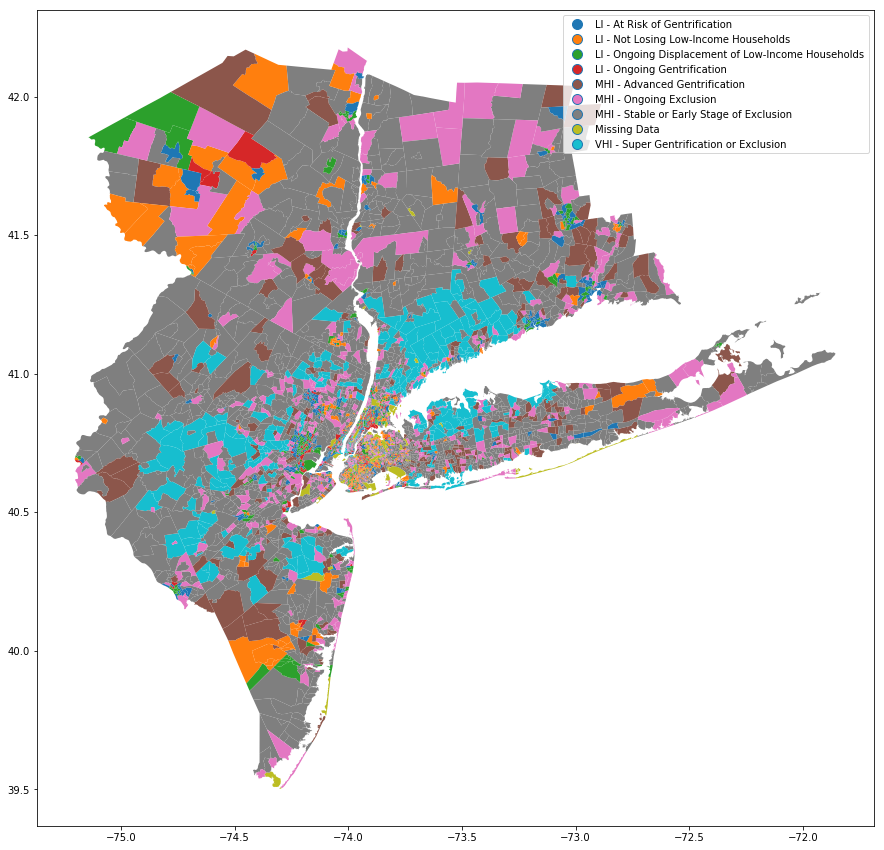

In [26]:
figure, ax = plt.subplots(figsize=(15, 15))
mergedgpd.plot(column='Type_1.19',legend = True, ax=ax)

# Spatail Join
- Spatail join by Census Tract
- map Businesses


In [27]:
mergedgpd.crs, data.crs, mergedgpd.shape, data.shape

(None, {'init': 'epsg:4326'}, (5290, 3), (106287, 11))

In [28]:
mergedgpd.crs = {'init' :'epsg:4326'}

In [29]:
mergedgpd.crs

{'init': 'epsg:4326'}

In [30]:
data_sjoined = gpd.sjoin(mergedgpd,Fq_dummies, op="contains")

In [31]:
# data_sjoined

In [32]:
# list(data_sjoined.columns)

In [33]:
data_sjoined_sum = data_sjoined.groupby(by='GEOID').sum()
print(data_sjoined_sum.shape,data_sjoined_sum.columns)
data_sjoined_sum_merged = data_sjoined_sum.merge(mergedgpd.loc[:,['GEOID','Type_1.19', 'geometry']],on='GEOID')
print(data_sjoined_sum_merged.shape,data_sjoined_sum_merged.columns)
data_sjoined_sum_merged = gpd.GeoDataFrame(data_sjoined_sum_merged)
print(data_sjoined_sum_merged.shape,data_sjoined_sum_merged.columns)

(3009, 710) Index(['index_right', 'Rating', 'Checkins', 'Users', 'Visits', 'Type_ATM',
       'Type_Accessories Store', 'Type_Acupuncturist', 'Type_Adult Boutique',
       'Type_Adult Education Center',
       ...
       'Category_Leisure', 'Category_Mobility', 'Category_Nutrition',
       'Category_Personal care', 'Category_Social', 'Category_Taking care',
       'Category_Unknown', 'Class_', 'Class_Necessary', 'Class_Optional'],
      dtype='object', length=710)
(3009, 713) Index(['GEOID', 'index_right', 'Rating', 'Checkins', 'Users', 'Visits',
       'Type_ATM', 'Type_Accessories Store', 'Type_Acupuncturist',
       'Type_Adult Boutique',
       ...
       'Category_Nutrition', 'Category_Personal care', 'Category_Social',
       'Category_Taking care', 'Category_Unknown', 'Class_', 'Class_Necessary',
       'Class_Optional', 'Type_1.19', 'geometry'],
      dtype='object', length=713)
(3009, 713) Index(['GEOID', 'index_right', 'Rating', 'Checkins', 'Users', 'Visits',
       'Type_ATM

In [34]:
Fq_dummies.shape,data_sjoined_sum.shape, len(data_sjoined_sum_merged.GEOID.unique())

((106287, 716), (3009, 710), 3009)

In [35]:
data_sjoined_sum_merged.rename(columns={"Type_1.19": "Typologies"}, inplace = True)

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


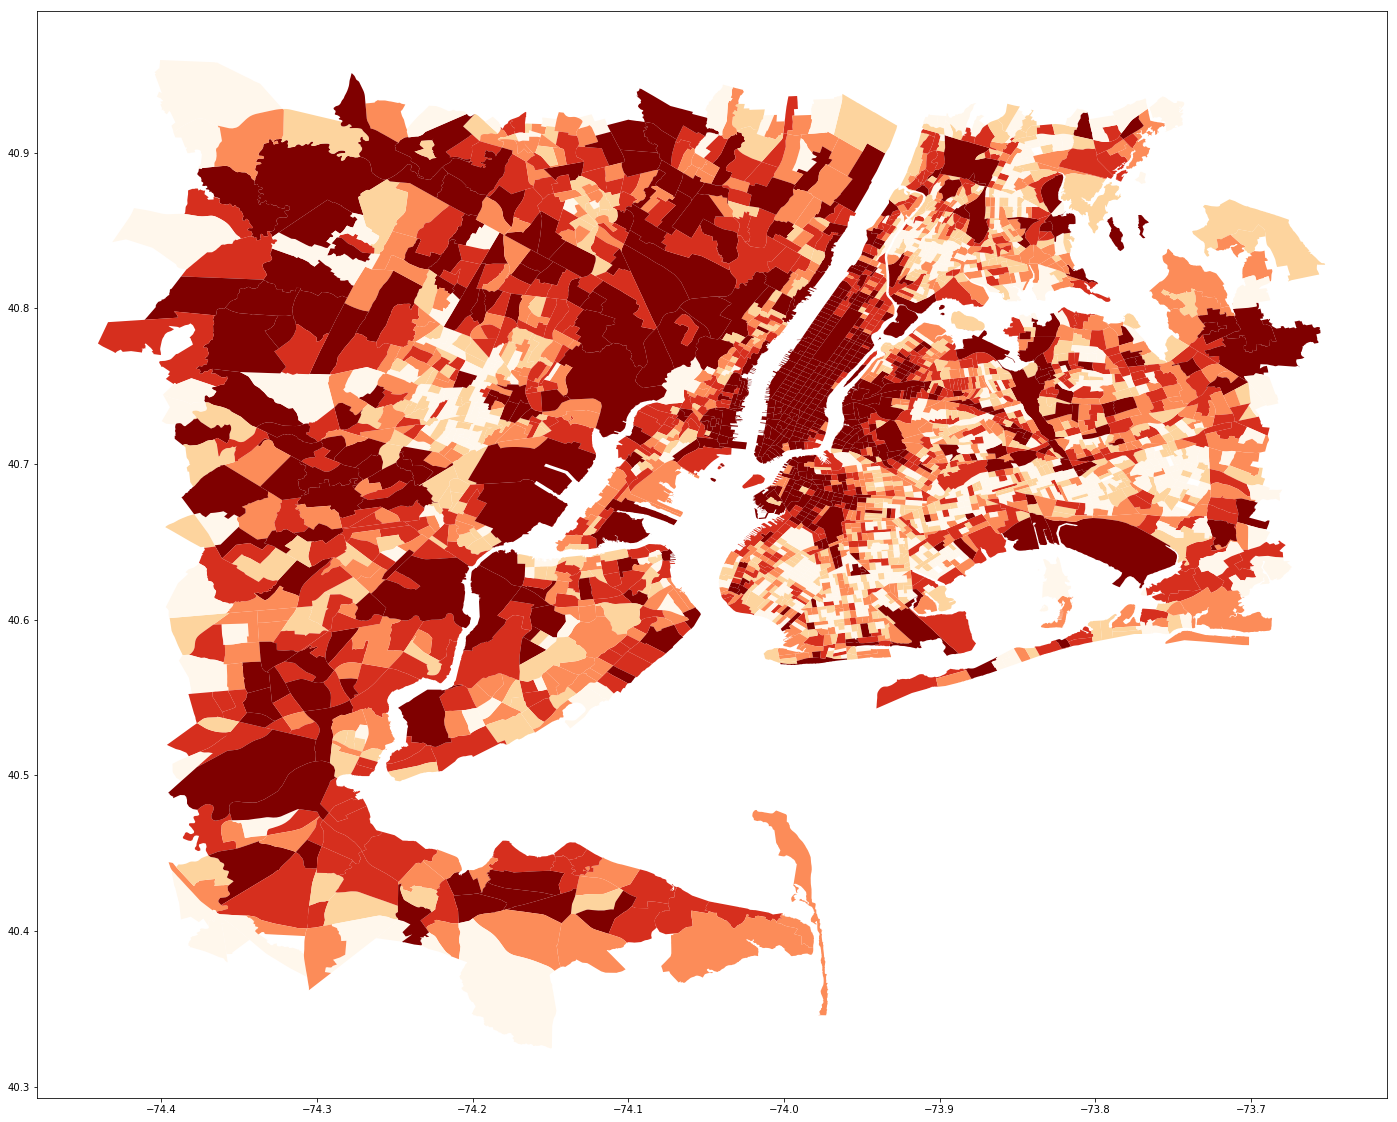

In [36]:
plt.rcParams['figure.figsize'] = (30, 20)
ax = data_sjoined_sum_merged.plot(column='Checkins', scheme='quantiles', cmap='OrRd')
ax.legend()

In [37]:
data_sjoined_sum_merged.drop(columns= 'index_right',inplace=True)
data_sjoined_sum_merged.iloc[:,:6]
data_sjoined_sum_merged.columns

Index(['GEOID', 'Rating', 'Checkins', 'Users', 'Visits', 'Type_ATM',
       'Type_Accessories Store', 'Type_Acupuncturist', 'Type_Adult Boutique',
       'Type_Adult Education Center',
       ...
       'Category_Nutrition', 'Category_Personal care', 'Category_Social',
       'Category_Taking care', 'Category_Unknown', 'Class_', 'Class_Necessary',
       'Class_Optional', 'Typologies', 'geometry'],
      dtype='object', length=712)

In [38]:
# sfig = pd.scatter_matrix(data_sjoined_sum_merged.iloc[:,:6], s=30, figsize=(10, 10), diagonal='kde')

In [39]:
data_sjoined_sum_merged.columns

Index(['GEOID', 'Rating', 'Checkins', 'Users', 'Visits', 'Type_ATM',
       'Type_Accessories Store', 'Type_Acupuncturist', 'Type_Adult Boutique',
       'Type_Adult Education Center',
       ...
       'Category_Nutrition', 'Category_Personal care', 'Category_Social',
       'Category_Taking care', 'Category_Unknown', 'Class_', 'Class_Necessary',
       'Class_Optional', 'Typologies', 'geometry'],
      dtype='object', length=712)

# Part II. Modeling
### Analysis ## FOURSQUARE ONLY

# Spatial Lag Deciles
## in order to account for neighbouring census tracts create a spatial weights matrix to assess neighbour distances for the CTs geometries - we use queens weights. For theoretical details on this see:
# [Anselin Rey & Li 2014](http://www.tandfonline.com/doi/full/10.1080/13658816.2014.917313?scroll=top&needAccess=true)

In [65]:
X_foursquare = data_sjoined_sum_merged

In [43]:
impoidsrt pysal as ps
qW_CT = ps.weights.Queen.from_dataframe(X_foursquare)
# the weight matrix
Wmatrix,  = qW_CT.full()
Wmatrix.shape

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/pysal/weights/weights.py:189: UserWarning: There are 5 disconnected observations
  warnings.warn("There are %d disconnected observations" % ni)
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/pysal/weights/weights.py:190: UserWarning: Island ids: 599, 1103, 1905, 2996, 3008
  warnings.warn("Island ids: %s" % ', '.join(str(island) for island in self.islands))


(3009, 3009)

In [46]:
len(ids)
# 

3009

In [98]:
Wmatrix

array([[ 0.,  0.,  1., ...,  0.,  0.,  0.],
       [ 0.,  0.,  1., ...,  0.,  0.,  0.],
       [ 1.,  1.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  1.,  0.],
       [ 0.,  0.,  0., ...,  1.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

In [99]:
# print(X_foursquare.shape)
# X_foursquare = X_foursquare.drop(['Typologies','GEOID','geometry'],axis =1).copy()
# print(X_foursquare.shape)

# X_foursquare.columns

In [100]:
X_foursquare['Checkins'].mean()
X_foursquare[Wmatrix[0]!=0]


,Rating,Checkins,Users,Visits,Type_ATM,Type_Accessories Store,Type_Acupuncturist,Type_Adult Boutique,Type_Adult Education Center,Type_Advertising Agency,...,Category_Leisure,Category_Mobility,Category_Nutrition,Category_Personal care,Category_Social,Category_Taking care,Category_Unknown,Class_,Class_Necessary,Class_Optional
2,13.6,4444,1722,6407,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,5.0,3.0,3.0,3.0,0.0,1.0,1.0,10.0,16.0
3,13.4,3279,1427,4469,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,3.0,3.0,0.0,5.0
95,28.6,3461,1922,5528,0.0,0.0,0.0,0.0,0.0,0.0,...,3.0,5.0,2.0,7.0,2.0,4.0,5.0,5.0,12.0,23.0
96,71.1,7026,3914,10881,0.0,0.0,0.0,0.0,0.0,0.0,...,4.0,5.0,6.0,4.0,16.0,6.0,5.0,5.0,23.0,33.0
97,13.2,1240,390,1659,0.0,0.0,0.0,0.0,0.0,0.0,...,3.0,1.0,1.0,4.0,3.0,2.0,2.0,2.0,7.0,16.0


In [102]:
# plt.rcParams['figure.figsize'] = (5, 5)
# ax = X_foursquare[Wmatrix[101] != 0].plot(column='Checkins', scheme='quantiles', cmap='OrRd')
# ax.legend()

In [107]:
# obtain averages ::::
print(X_foursquare.shape,Wmatrix.shape)
for i, column in enumerate(X_foursquare.columns):
    X_foursquare[column+'_ave'] = X_foursquare[column]
for i, column in enumerate(X_foursquare.columns):
#     print(i,column)
    X_foursquare[column+'_ave'][i] = X_foursquare[column][Wmatrix[0]!=0].mean()
print(X_foursquare.shape,Wmatrix.shape)

(3009, 709) (3009, 3009)
0 Rating


/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


1 Checkins
2 Users
3 Visits
4 Type_ATM
5 Type_Accessories Store
6 Type_Acupuncturist
7 Type_Adult Boutique
8 Type_Adult Education Center
9 Type_Advertising Agency
10 Type_Afghan Restaurant
11 Type_African Restaurant
12 Type_Airport
13 Type_Airport Food Court
14 Type_Airport Gate
15 Type_Airport Lounge
16 Type_Airport Service
17 Type_Airport Terminal
18 Type_Airport Tram
19 Type_Alternative Healer
20 Type_American Restaurant
21 Type_Amphitheater
22 Type_Animal Shelter
23 Type_Antique Shop
24 Type_Apres Ski Bar
25 Type_Aquarium
26 Type_Arcade
27 Type_Arepa Restaurant
28 Type_Argentinian Restaurant
29 Type_Art Gallery
30 Type_Art Museum
31 Type_Art Studio
32 Type_Arts & Crafts Store
33 Type_Arts & Entertainment
34 Type_Asian Restaurant
35 Type_Assisted Living
36 Type_Astrologer
37 Type_Athletics & Sports
38 Type_Auditorium
39 Type_Australian Restaurant
40 Type_Austrian Restaurant
41 Type_Auto Dealership
42 Type_Auto Garage
43 Type_Auto Workshop
44 Type_Automotive Shop
45 Type_BBQ Joint
46

357 Type_Japanese Restaurant
358 Type_Jazz Club
359 Type_Jewelry Store
360 Type_Jewish Restaurant
361 Type_Juice Bar
362 Type_Karaoke Bar
363 Type_Kebab Restaurant
364 Type_Kids Store
365 Type_Kingdom Hall
366 Type_Kitchen Supply Store
367 Type_Knitting Store
368 Type_Korean Restaurant
369 Type_Kosher Restaurant
370 Type_Laboratory
371 Type_Lake
372 Type_Language School
373 Type_Laser Tag
374 Type_Latin American Restaurant
375 Type_Laundromat
376 Type_Laundry Service
377 Type_Law School
378 Type_Lawyer
379 Type_Leather Goods Store
380 Type_Lebanese Restaurant
381 Type_Library
382 Type_Light Rail Station
383 Type_Lighthouse
384 Type_Lighting Store
385 Type_Lingerie Store
386 Type_Liquor Store
387 Type_Locksmith
388 Type_Lounge
389 Type_Luggage Store
390 Type_Mac & Cheese Joint
391 Type_Malay Restaurant
392 Type_Marijuana Dispensary
393 Type_Market
394 Type_Martial Arts Dojo
395 Type_Massage Studio
396 Type_Maternity Clinic
397 Type_Mattress Store
398 Type_Medical Center
399 Type_Medical

KeyError: 'Rating_ave_ave'

In [ ]:
X_foursquare.columns[700:800]

In [39]:
# Features = ['All','Visits_Only','No_Visits','Class','Top11_Types']
# X_foursquare ={}
# for feature in Features:
#     X_foursquare[feature] = data_sjoined_sum_merged.drop(['Typologies','GEOID','geometry'],axis =1).copy()

# # All
# # Visits_Only
# X_foursquare['Visits_Only'] = X_foursquare['Visits_Only'].iloc[:,:4]

# # No_Visits
# X_foursquare['No_Visits'] = data_sjoined_sum_merged.drop(['Visits','Rating','Users','Checkins','Typologies','GEOID','geometry'],axis =1).copy()

# # Class
# X_foursquare['Class'] = X_foursquare['Class'].iloc[:,-14:]

# # Topp1_Types
# type_cols = ['Type_Pizza Place','Type_Italian Restaurant','Type_Coffee Shop','Type_Bar','Type_Donut Shop',
#              'Type_Sandwich Place','Type_Fast Food Restaurant','Type_Chinese Restaurant','Type_American Restaurant',
#              'Type_Mexican Restaurant','Type_Deli / Bodega','Type_Café']
# X_foursquare['Top11_Types'] = X_foursquare['Top11_Types'][type_cols]

# y = data_sjoined_sum_merged.Typologies

# for feature in Features:

#     print(X_foursquare[feature].shape)
#     X_foursquare[feature].dropna(inplace=True)
#     print(X_foursquare[feature].shape)

In [130]:
### Preprocessing Data
### Preprocessing Data
# X_foursquare = data_sjoined_sum_merged.drop(['Typologies', 'geometry'],axis =1).copy()
y = data_sjoined_sum_merged.Typologies

## change to zeros

# replace with mean/median

# create a new

print(X_foursquare.shape)
# X_foursquare.replace(False,0,inplace=True)
# X_foursquare.replace('FALSE',0,inplace=True)
# X_foursquare.replace('#NULL!',0,inplace=True)
# X_foursquare.replace(nan,0,inplace=True)

X_foursquare.dropna(inplace=True)
print(X_foursquare.shape)

(3009, 1418)
(3009, 1418)


In [139]:
# Normalize
model = {}
for m in models:
    model[m] = {}
modelslist = ['Logit','DT','RF','SVM'] 

import sklearn.preprocessing as preprocessing
from sklearn.preprocessing import MinMaxScaler
min_max_scaler = MinMaxScaler()

models = ['o','scaled','minmaxed']
Xdata_scaled = preprocessing.scale(X_foursquare)
# ydata_scaled = preprocessing.scale(y)

Xdata_minmaxed = min_max_scaler.fit_transform(X_foursquare)
# ydata_minmaxed = min_max_scaler.fit_transform(y)

dictx = {}
dictx['o'] = X_foursquare
dictx['scaled'] = Xdata_scaled
dictx['minmaxed'] = Xdata_minmaxed
                    

# x = dictx[model][0]
# y = dictx[model][1]

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/ipykernel_launcher.py:12: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by the scale function.
  if sys.path[0] == '':
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [140]:
# for string in data_sjoined_sum_merged.columns:
#     print(string)
# #     data_sjoined_sum_merged.rename({string:str(string.encode('utf-8'))},axis='columns',inplace=True)
# list(data_sjoined_sum_merged.columns)

In [141]:
data_sjoined_sum_merged.columns

Index(['GEOID', 'Rating', 'Checkins', 'Users', 'Visits', 'Type_ATM',
       'Type_Accessories Store', 'Type_Acupuncturist', 'Type_Adult Boutique',
       'Type_Adult Education Center',
       ...
       'Category_Nutrition', 'Category_Personal care', 'Category_Social',
       'Category_Taking care', 'Category_Unknown', 'Class_', 'Class_Necessary',
       'Class_Optional', 'Typologies', 'geometry'],
      dtype='object', length=712)

In [142]:
X_foursquare.columns

Index(['Rating', 'Checkins', 'Users', 'Visits', 'Type_ATM',
       'Type_Accessories Store', 'Type_Acupuncturist', 'Type_Adult Boutique',
       'Type_Adult Education Center', 'Type_Advertising Agency',
       ...
       'Category_Leisure_ave', 'Category_Mobility_ave',
       'Category_Nutrition_ave', 'Category_Personal care_ave',
       'Category_Social_ave', 'Category_Taking care_ave',
       'Category_Unknown_ave', 'Class__ave', 'Class_Necessary_ave',
       'Class_Optional_ave'],
      dtype='object', length=1418)

In [143]:
from sklearn.model_selection import train_test_split

X_train = {}
X_test = {}
y_train = {}
y_test = {}
for m in models:

    X_train[m], X_test[m], y_train[m], y_test[m] = train_test_split(dictx[m], y, test_size = 0.3, random_state = 1)    
    #x >> dictx[m][0]
    # y =>> dictx[m][1]


In [144]:

model

{'minmaxed': {}, 'o': {}, 'scaled': {}}

# LR

In [145]:
## Logistic Reeg
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, classification_report
import matplotlib.pylab

for m in models:
#     dictx[m]
#     model[m]
# X_train[m], X_test[m], y_train[m], y_test[m]
    logit_1 = LogisticRegression(C = 10000)
#     print(X_train[m].shape,y_train[m].shape)
    logit_1.fit(X_train[m], y_train[m])
    print(logit_1.score(X_test[m],y_test[m]))
    model[m]['Logit'] = logit_1.score(X_test[m],y_test[m])

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:459: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/lo

0.27796234773


/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:459: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


0.178294573643
0.210409745293


# DT

In [146]:
# Decision Tree
# Decision Tree

In [147]:
# This time we'll use max_depth to control the complexity of the tree, still using the same train/test split as above,
# and optimize the parameter value using GridSearchCV.
for m in models:
    #     dictx[m]
    #     model[m]
    param_grid = {'max_depth':range(1,11),'max_leaf_nodes':range(2,11)}
    dt=DecisionTreeClassifier()
    gr=GridSearchCV(dt,param_grid=param_grid,scoring='accuracy')
    ds=gr.fit(X_train[m],y_train[m])
    print (ds.best_params_)
    print(gr.score(X_test[m],y_test[m]))

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/sklearn/model_selection/_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


{'max_depth': 1, 'max_leaf_nodes': 2}
0.28349944629


/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/sklearn/model_selection/_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


{'max_depth': 1, 'max_leaf_nodes': 2}
0.28349944629


/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/sklearn/model_selection/_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


{'max_depth': 1, 'max_leaf_nodes': 2}
0.28349944629


In [148]:
seed = 5
# print(y_train.shape, X_train.shape)
for m in models:
    #     dictx[m]
    #     model[m]
    OS = []
    for c in range(5):
        dt=DecisionTreeClassifier()
        dt = DecisionTreeClassifier(max_depth=ds.best_params_['max_depth'],max_leaf_nodes=ds.best_params_['max_leaf_nodes'])
        dt.fit(X_train[m], y_train[m])
        pred=dt.predict_proba(X_test[m])[:,1]
        OS.append(dt.score(X_test[m],y_test[m]))
    print(dt.score(X_test[m],y_test[m]))
    model[m]['DT'] = mean(OS)
model

0.28349944629
0.28349944629
0.28349944629


{'minmaxed': {'DT': 0.28349944629014395, 'Logit': 0.21040974529346623},
 'o': {'DT': 0.28349944629014395, 'Logit': 0.27796234772978962},
 'scaled': {'DT': 0.28349944629014395, 'Logit': 0.17829457364341086}}

# Random Forest

In [149]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score

In [150]:
def featureImportancePlot(rf, labels):
    '''plots feature importance for random forest
    rf: the random forest model fit to the data
    labels: the names of the features
    '''
    
    importances = rf.feature_importances_[:10]
    indices = np.argsort(importances)[::-1]
    std = np.std([tree.feature_importances_ for tree in rf.estimators_],
             axis=0)

    pl.figure()
    pl.title("Feature importances")
    pl.bar(range(indices.shape[0]), rf.feature_importances_[indices],
       color="SteelBlue", yerr=std[indices], align="center")
    pl.xticks(range(indices.shape[0]), np.array(labels)[indices], rotation=90)
    pl.xlim([-1, indices.shape[0]])
    pl.show()


/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/sklearn/model_selection/_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


{'n_estimators': 6, 'max_depth': 5, 'max_leaf_nodes': 7}
0.285714285714


/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0

0.281284606866


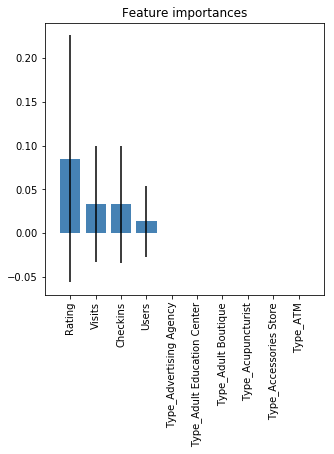

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/sklearn/model_selection/_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/sklearn/ens

{'n_estimators': 1, 'max_depth': 7, 'max_leaf_nodes': 5}
0.275747508306
0.28349944629


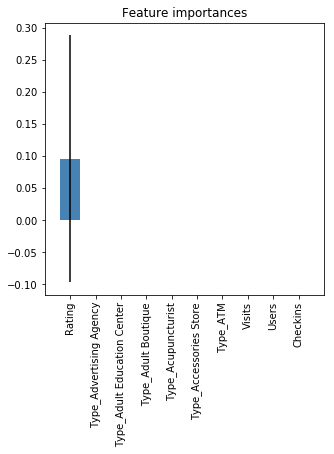

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/sklearn/model_selection/_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/sklearn/ens

{'n_estimators': 8, 'max_depth': 5, 'max_leaf_nodes': 10}
0.284606866002


/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.281284606866


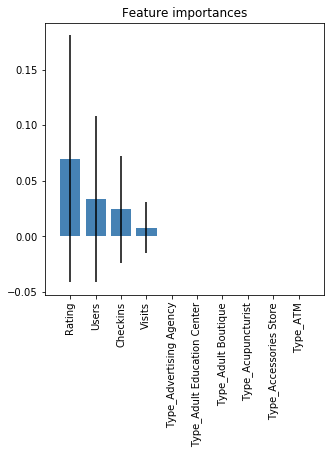

{'minmaxed': {'DT': 0.28349944629014395,
  'Logit': 0.21040974529346623,
  'RF': 0.28394241417497235},
 'o': {'DT': 0.28349944629014395,
  'Logit': 0.27796234772978962,
  'RF': 0.28327796234772978},
 'scaled': {'DT': 0.28349944629014395,
  'Logit': 0.17829457364341086,
  'RF': 0.28372093023255812}}

In [151]:
for m in models:
    #     dictx[m]
    #     model[m]

    param_grid = {'max_depth':range(1,11),'n_estimators':range(1,11),'max_leaf_nodes':range(2,11)}
    rf=RandomForestClassifier()
    gr=GridSearchCV(rf,param_grid=param_grid,scoring='accuracy')
    rs=gr.fit(X_train[m],y_train[m])
    print (rs.best_params_)
    print(gr.score(X_test[m],y_test[m]))
    OS = []
    for c in range(5):
        rf=RandomForestClassifier()
        rf = RandomForestClassifier(max_depth=rs.best_params_['max_depth'],max_leaf_nodes=rs.best_params_['max_leaf_nodes'])
        rf.fit(X_train[m], y_train[m])
        pred=rf.predict_proba(X_test[m])[:,1]
        OS.append(rf.score(X_test[m],y_test[m]))
    print(rf.score(X_test[m],y_test[m]))
    model[m]['RF'] = mean(OS)
    featureImportancePlot(rf, X_foursquare.columns)
model
  

In [ ]:
# SVM

In [154]:
from sklearn.model_selection import GridSearchCV

# When C is very small, we are willing to tolerate more mistakes. If C is very big, this
# means we hardly tolerate any mistakes. So, we cannot choose a very large C if our data is not
# really separable. Let's however choose from a broad range of reasonable options.
# param_grid = {'kernel':['linear'],'C':[np.exp(i) for i in np.linspace(-10,10,10)]}
# OS = []
for m in models:
    #     dictx[m]
        #     model[m]
    rr = svm.SVC()
    rr.fit(X_train[m], y_train[m])
    correct=1.0*(rr.predict(X_test[m])==np.asarray(y_test[m])).sum()/len(y_test[m])
    print(correct)
    print(rr.score(X_test[m],y_test[m]))
    OS.append(correct)
    model[m]['SVM'] = mean(OS)
model

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


0.276854928018
0.276854928018


/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


0.292358803987
0.292358803987


/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


0.28349944629
0.28349944629


{'minmaxed': {'DT': 0.28349944629014395,
  'Logit': 0.21040974529346623,
  'RF': 0.28394241417497235,
  'SVM': 0.28405315614617943},
 'o': {'DT': 0.28349944629014395,
  'Logit': 0.27796234772978962,
  'RF': 0.28327796234772978,
  'SVM': 0.28276116648209676},
 'scaled': {'DT': 0.28349944629014395,
  'Logit': 0.17829457364341086,
  'RF': 0.28372093023255812,
  'SVM': 0.28413225755418453}}

- You can refer to https://github.com/mv1742/updny_2

In [155]:
for i in modelslist:
    print(i)
for m in models:
    print(m)
    print((model[m]))
    print(mean(list(model[m].values())))
model.keys(), model.values()

Logit
DT
RF
SVM
o
{'DT': 0.28349944629014395, 'SVM': 0.28276116648209676, 'RF': 0.28327796234772978, 'Logit': 0.27796234772978962}
0.281875230712
scaled
{'DT': 0.28349944629014395, 'SVM': 0.28413225755418453, 'RF': 0.28372093023255812, 'Logit': 0.17829457364341086}
0.25741180193
minmaxed
{'DT': 0.28349944629014395, 'SVM': 0.28405315614617943, 'RF': 0.28394241417497235, 'Logit': 0.21040974529346623}
0.265476190476


(dict_keys(['scaled', 'o', 'minmaxed']),
 dict_values([{'DT': 0.28349944629014395, 'SVM': 0.28413225755418453, 'RF': 0.28372093023255812, 'Logit': 0.17829457364341086}, {'DT': 0.28349944629014395, 'SVM': 0.28276116648209676, 'RF': 0.28327796234772978, 'Logit': 0.27796234772978962}, {'DT': 0.28349944629014395, 'SVM': 0.28405315614617943, 'RF': 0.28394241417497235, 'Logit': 0.21040974529346623}]))

In [156]:
### Neighbours:::
{'minmaxed': {'DT': 0.28349944629014395,
  'Logit': 0.21040974529346623,
  'RF': 0.28394241417497235,
  'SVM': 0.28405315614617943},
 'o': {'DT': 0.28349944629014395,
  'Logit': 0.27796234772978962,
  'RF': 0.28327796234772978,
  'SVM': 0.28276116648209676},
 'scaled': {'DT': 0.28349944629014395,
  'Logit': 0.17829457364341086,
  'RF': 0.28372093023255812,
  'SVM': 0.28413225755418453}}

{'minmaxed': {'DT': 0.28349944629014395,
  'Logit': 0.21040974529346623,
  'RF': 0.28394241417497235,
  'SVM': 0.28405315614617943},
 'o': {'DT': 0.28349944629014395,
  'Logit': 0.2779623477297896,
  'RF': 0.2832779623477298,
  'SVM': 0.28276116648209676},
 'scaled': {'DT': 0.28349944629014395,
  'Logit': 0.17829457364341086,
  'RF': 0.2837209302325581,
  'SVM': 0.28413225755418453}}